In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import savgol_filter
from pathlib import Path

In [145]:
fldr_path = Path(r'/Users/jiahaozhan/Desktop/data and scripts/Bidi_data')
file_name = 'patch_100m_spool_opm_ch2_ch1_20MHz_ch2_20MHz_max.json'
file_path = fldr_path / file_name

with open(file_path, 'r') as file:
    data = json.load(file)

keys = list(data.keys())

In [146]:
data['5']

[['fine', 3], {'0': 101.527}, {'0': [0.0, 0.2924]}]

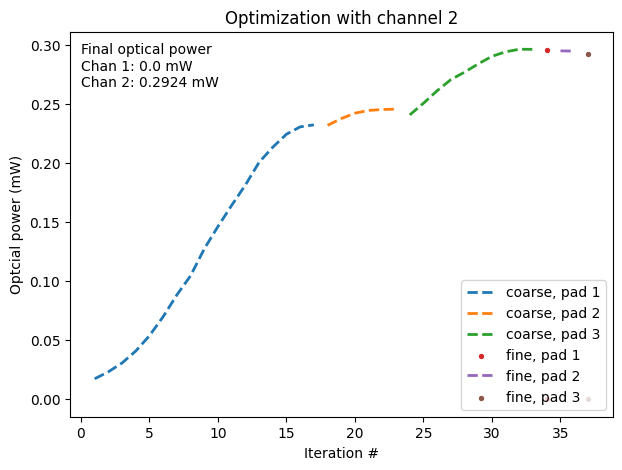

In [152]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

final_opt = data['5'][-1]
last_key = list(final_opt.keys())[-1]
ch1_final_pwr, ch2_final_pwr = final_opt[last_key][0], final_opt[last_key][1]
txts = f"Final optical power\nChan 1: {ch1_final_pwr} mW\nChan 2: {ch2_final_pwr} mW"

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
last_iter = 0
for k in keys:
    label = f"{data[k][0][0]}, pad {data[k][0][1]}"
    iter = []
    ch1_pwrs, ch2_pwrs = [], []
    for i, pwrs in data[k][2].items():
        iter.append(int(i)+last_iter+1)
        ch1_pwrs.append(pwrs[0])
        ch2_pwrs.append(pwrs[1])
    last_iter = iter[-1]
    if len(iter) > 1:
        # ax.plot(iter, ch1_pwrs, '-', linewidth=2, color=colors[int(k)], label=label)
        ax.plot(iter, ch2_pwrs, '--', linewidth=2, color=colors[int(k)],label=label)
    else:
        ax.scatter(iter, ch1_pwrs, s=8, color=colors[int(k)], label=label)
        ax.scatter(iter, ch2_pwrs, s=8, color=colors[int(k)])
        
ax.set_xlabel('Iteration #')
ax.set_ylabel('Optcial power (mW)')
ax.set_title('Optimization with channel 2')
ax.text(0, 0.265, txts)
ax.legend(loc='lower right')

In [2]:
def smooth_triangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [16]:
fldr_path = Path(r'/Users/jiahaozhan/Desktop/data and scripts/Bidi_data/pol_roc_data')
file_name = 'pol_roc_data_1.csv'
# file_name = 'no_perturbation.csv'
file_dir = fldr_path / file_name

df = pd.read_csv(file_dir)
print(df.columns)
t = np.array(df['time'])
amp = np.array(df['amp'])*1000
amp_smoothed = smooth_triangle(amp, 100)

Index(['time', 'amp'], dtype='object')


2003636 9.999999999999989e-08
1e-07


Text(0.5, 1.0, 'Frequency domain - dB')

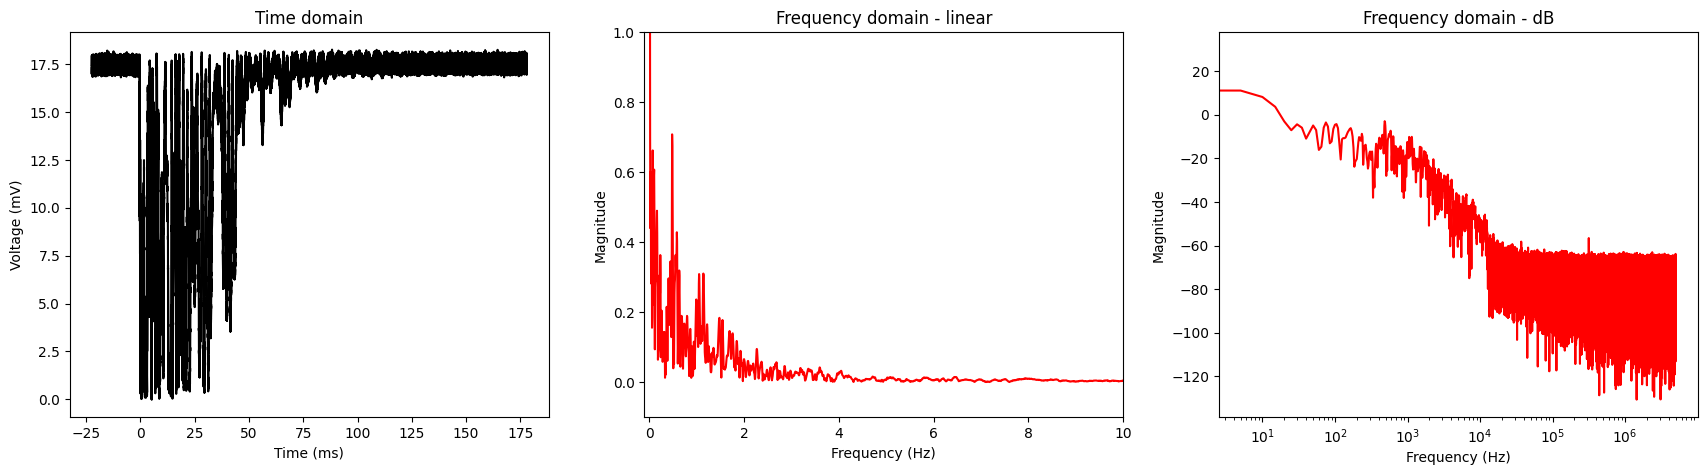

In [17]:
N = len(t)
delta_t = []
for i in range(int(N-1)):
    delta_t.append(t[i+1] - t[i])
print(N, np.average(delta_t))
dt = round(np.average(delta_t), 7)
print(dt)

freqs = fftfreq(N, dt)
amp_fft = fft(amp)
amp_smoothed_fft = fft(amp_smoothed)

fig, axes = plt.subplots(1, 3, figsize=(21, 5))
ax = axes[0]
ax.plot(t*1000, amp, color='k')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Time domain')

ax = axes[1]
ax.plot(np.divide(freqs[:N//2], 1000), np.abs(amp_fft[:N//2])*2/N, color='r')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency domain - linear')
ax.set_xlim([-0.1, 10])
ax.set_ylim([-0.1, 1])

ax = axes[2]
amp_dB = 20*np.log10(np.abs(amp_fft[:N//2])*2/N)
ax.plot(freqs[:N//2], amp_dB, color='r')
ax.set_xscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_title('Frequency domain - dB')

Text(0.5, 1.0, '1D derivative')

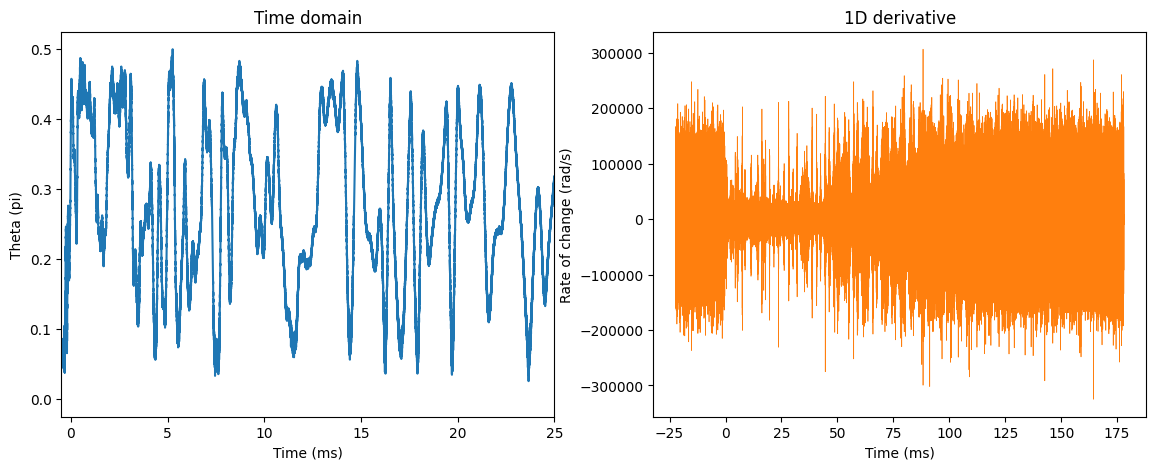

In [19]:
V_min = np.min(amp)
V_max = np.max(amp - V_min)
V_norm = (amp - V_min)/V_max

theta = np.arccos(np.sqrt(V_norm))/np.pi
# theta_smoothed = smooth_triangle(theta, 100)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(t*1000, theta, color=colors[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta (pi)')
ax.set_title('Time domain')
ax.set_xlim([-0.5, 25])

ax = axes[1]
time_deriv = np.gradient(theta, t)
ax.plot(t*1000, time_deriv, color=colors[1], linewidth=0.5)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Rate of change (rad/s)')
ax.set_title('1D derivative')

(0.0, 10.0)

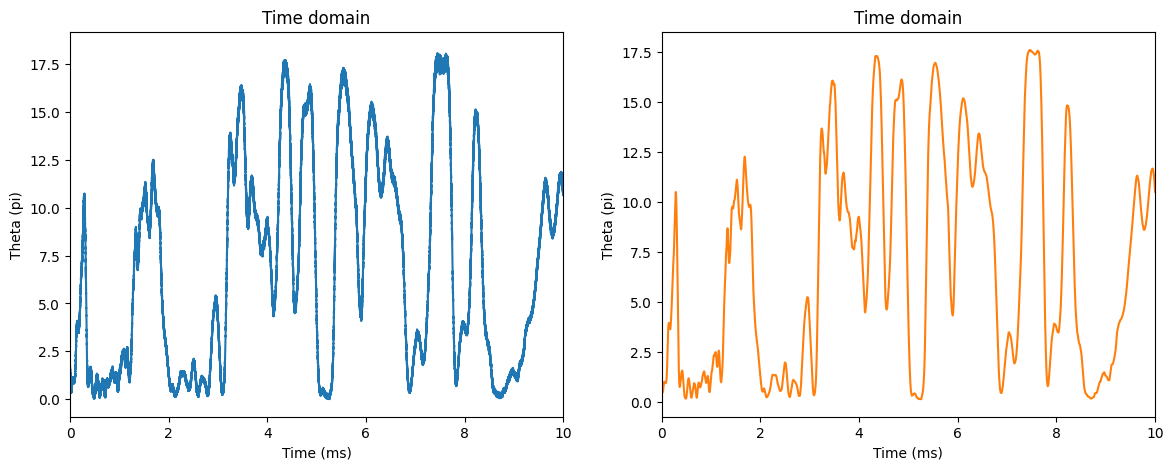

In [149]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(t*1000, amp, color=colors[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta (pi)')
ax.set_title('Time domain')
ax.set_xlim([0, 10])

ax = axes[1]

ax.plot(t*1000, amp_smoothed, color=colors[1])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta (pi)')
ax.set_title('Time domain')
ax.set_xlim([0, 10])